# Financial Risk Metrics
---
This notebook measures the risk characteristics of the S&P 500 index throughout its entire history. The notebook starts by calculating static risk metrics. Then the notebook explores tail-end risk metrics to quantify large losses with small probabilities. To conclude the experiment, we calculate and observe temporal risk metrics.

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf

# Import settings
plt.style.use('ggplot')

# Download historical S&P 500 data, calculate daily returns
data = yf.download('^GSPC', period='max', interval='1d', auto_adjust=True)['Close']
data['returns'] = data['^GSPC'].pct_change()
data.dropna(inplace=True)

# Min Return
# Max Return
# VaR
# Expected Shortfall
# Lower Partial Standard Deviation
# Relative Frequency of 3-Sigma Returns
# Rolling Standard Deviation
# Term Structure of Mean
# Term Structure of Volatility
# Term Structure of Up/Down Volatility
# Term Structure of Skew
# Term Structure of Kurtosis

[*********************100%***********************]  1 of 1 completed


Average Return:      0.00030959497714619583
Standard Deviation:  0.011954477335647327
Skew of Returns:     -0.10902832369081612
Kurtosis of Returns: 17.226106473297577


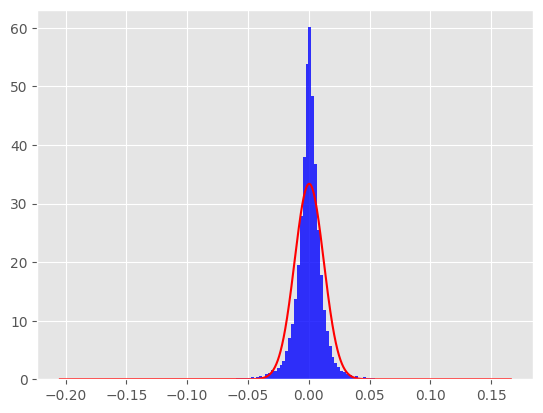

In [52]:
# Plot the frequency distribution of returns.
# Overlay a normal distribution with same mean (u) and
# standard deviation (sd) as the historical return set.

u = np.mean(data['returns'])
sd = np.std(data['returns'])
skew = data['returns'].skew()
kurt = data['returns'].kurt()

print(f'Average Return:      {u}')
print(f'Standard Deviation:  {sd}')
print(f'Skew of Returns:     {skew}')
print(f'Kurtosis of Returns: {kurt}')

# Calulate the normal distribution
x = np.linspace(min(data['returns']), max(data['returns']), len(data['returns']))
y = stats.norm.pdf(x, u, sd)

fig, ax = plt.subplots()

# Plot the return frequency
nBins = int(np.sqrt(len(data['returns'])))
ax.hist(data['returns'], bins=nBins, alpha=0.8, color='blue', label='Return Distribution', density=True)

# Plot the normal distribution
ax.plot(x, y, color='red', label='Normal')
plt.show()

### Summary of Above